# Experiment 1

## Goal

The goal of the first experiment is to test the differentiable diffusion process.

## Approach 

Visualize the loss landscape and gradients for a range of diffusion coeffcients. As our loss measurement, we compare a dataset generated with the desired coefficients to the data generated by the current parameters using a pixel-wise loss function for each of the grids.

make the FHN functions available

In [1]:
import sys
sys.path.insert(0, '../../')

import modules

In [2]:
import torch as t
import numpy as np
import pandas as pd
from experiment_helper import chop_and_shuffle_data, generate_sequence, dataset_dist
from diffusion_gumbel import diffuse_STE
from tqdm import tqdm
import matplotlib.pyplot as plt
from os import path, getcwd
import os

set device

In [3]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate dataset

In [4]:
grid = t.zeros((2, 30, 30), device=device)
grid[:] = 50
grid[0,12:17] = 90

N = 100
num_steps = 1_000
DA = 0.1
DB = 0.4

sequence = generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=False,
    create_vis=False,
    save_steps=False,
    create_seq=True
)
dataset = chop_and_shuffle_data(sequence, shuffle=True)
dataset = dataset.to(device)
print(f"created dataset with shape: {dataset.shape}")

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:01<00:00, 888.29it/s]

created dataset with shape: torch.Size([999, 2, 2, 30, 30])


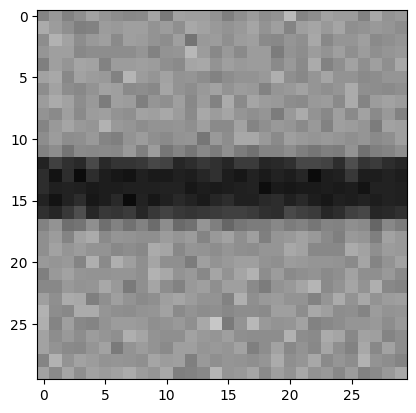

In [6]:
plt.imshow(sequence[999,0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=100)

save/load dataset for reference

In [7]:
t.save(dataset, path.join(getcwd(), "data", "dataset.pt"))

In [ ]:
dataset = t.load(path.join(getcwd(), "data", "dataset.pt"))

run the experiment

In [8]:
# define a sequence of DA values to test
DA_vals = t.linspace(0.0, 1.0, 100, device=device)
# define a sequence of DB values to test
DB_vals = t.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], device=device)

# create meshgrid for the coefficients
mesh_DA, mesh_DB = t.meshgrid(DA_vals, DB_vals)

# split the dataset for usage
X = dataset[:,0]
Y_obs = dataset[:,1]

N = 100

# collect the results of each test run here
gradients = np.zeros(mesh_DA.shape)
distances = np.zeros(mesh_DA.shape)
for DA_idx in tqdm(range(100)):
    for DB_idx in range(10):
        #init params
        DA = mesh_DA[DA_idx, DB_idx]
        DA.requires_grad_()
        DB = mesh_DB[DA_idx, DB_idx]
        
        # run one step of diffusion
        Y_sim = diffuse_STE(X, N, DA, DB)
        
        # calculate the loss
        dist_val = dataset_dist(X, Y_sim, Y_obs)
        distances[DA_idx, DB_idx] = dist_val.detach().cpu().numpy()
        
        # get the gradient
        gradient = t.autograd.grad(dist_val, DA)[0]
        gradients[DA_idx, DB_idx] = gradient.detach().cpu().numpy()
        

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 100/100 [07:55<00:00,  4.76s/it]


store the results

In [10]:
results = np.hstack((
    mesh_DA.cpu().numpy().flatten()[:,np.newaxis],
    mesh_DB.cpu().numpy().flatten()[:,np.newaxis],
    np.log(distances).flatten()[:,np.newaxis],
    gradients.flatten()[:,np.newaxis]
))

df = pd.DataFrame(results, columns=["DA", "DB", "log_distance", "gradient"])
df.to_csv(path.join(getcwd(), "data", "results.csv"))

In [22]:
distances.T.shape

(10, 100)

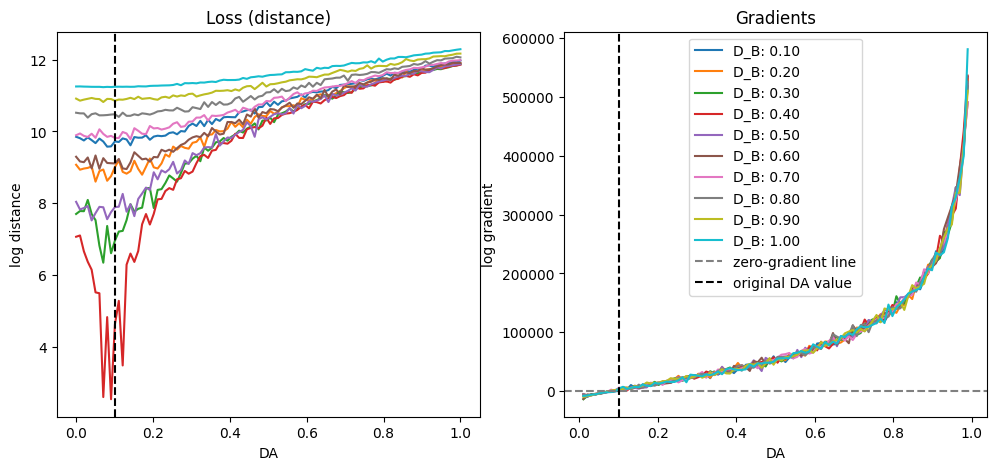

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
for idx in range(10):
    axs[0].plot(DA_vals.cpu(), np.log(np.array(distances.T[idx])), label=f"D_B: {DB_vals[idx]:.2f}")
    axs[1].plot(DA_vals.cpu(), np.array(gradients.T[idx]), label=f"D_B: {DB_vals[idx]:.2f}")
axs[0].set(title="Loss (distance)", xlabel="DA", ylabel="log distance")
axs[1].set(title="Gradients", xlabel="DA", ylabel="log gradient")

axs[0].axvline(0.1, color='black', linestyle="--", label="original DA value")
axs[1].axhline(0., color='gray', linestyle="--", label="zero-gradient line")
axs[1].axvline(0.1, color='black', linestyle="--", label="original DA value")

plt.legend()